<h1> Impor dan Eksplorasi Data

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns

In [2]:
df_data_1 = pd.read_csv('HR_comma_sep.csv')
df_data_2 = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df_data_3 = pd.read_csv('turnover.csv', encoding = 'ISO-8859-1')
df_model_1 = df_data_1.copy()
df_model_2 = df_data_2.copy()
df_model_3 = df_data_3.copy()

In [3]:
df_model_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# pengecekan data null untuk dataset 1-3
display(df_data_1.isnull().values.any())
display(df_data_2.isnull().values.any())
display(df_data_3.isnull().values.any())

False

False

False

In [5]:
# deklarasi kolom yang akan dihapus
drop2 = ['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18']
# drop kolom yang akan dihapus
df_model_2 = df_model_2.drop(drop2,axis=1)

In [6]:
# rename kolom target
df_model_1 = df_model_1.rename(columns={'left': 'churn'})
df_model_2 = df_model_2.rename(columns={'Attrition': 'churn'})
df_model_3 = df_model_3.rename(columns={'event': 'churn'})

# rename kolom treatment
df_model_1 = df_model_1.rename(columns={'promotion_last_5years': 'treatment'})
df_model_2 = df_model_2.rename(columns={'OverTime': 'treatment'})
df_model_3 = df_model_3.rename(columns={'coach': 'treatment'})

In [7]:
# deklarasi kolom string
string1, string2, string3 = ['salary'], ['churn',
                                         'treatment',
                                         'BusinessTravel'], ['treatment']
# observasi data unique
for col in string1:
    display(col, df_model_1[col].unique())
for col in string2:
    display(col, df_model_2[col].unique())
for col in string3:
    display(col, df_model_3[col].unique())

'salary'

array(['low', 'medium', 'high'], dtype=object)

'churn'

array(['Yes', 'No'], dtype=object)

'treatment'

array(['Yes', 'No'], dtype=object)

'BusinessTravel'

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

'treatment'

array(['no', 'yes', 'my head'], dtype=object)

In [8]:
# Deklarasi target dan treatment dataset 1
df_model_1.salary = df_model_1.salary.map({'low': 0, 'medium': 1, 'high':2})

In [9]:
# Deklarasi target dan treatment dataset 2
df_model_2.churn = df_model_2.churn.map({'Yes': 1, 'No': 0})
df_model_2.treatment = df_model_2.treatment.map({'Yes': 0, 'No': 1})
# Deklarasi BusinessTravel
df_model_2.BusinessTravel = df_model_2.BusinessTravel.map({'Non-Travel': 0,
                                                           'Travel_Rarely': 1,
                                                           'Travel_Frequently':2})

In [10]:
# Deklarasi target dan treatment dataset 3
df_model_3.treatment = df_model_3.treatment.map({'yes': 0, 'no': 1, 'my head':2})
df_model_3 = df_model_3.loc[df_model_3.treatment <=1].reset_index(drop=True)

In [11]:
# One-Hot Encoding untuk ketiga dataset:
df_model_1, df_model_inverse_1 = pd.get_dummies(df_model_1), pd.get_dummies(df_model_1)
df_model_2, df_model_inverse_2 = pd.get_dummies(df_model_2), pd.get_dummies(df_model_2)
df_model_3, df_model_inverse_3 = pd.get_dummies(df_model_3), pd.get_dummies(df_model_3)

In [12]:
# kalkulasi korelasi treatment 
def korelasi_treatment(df:pd.DataFrame):
    correlation = df[['treatment','churn']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['churn'] * 100,2)))

In [13]:
display(korelasi_treatment(df_model_1).iloc[0,0])
display(korelasi_treatment(df_model_2).iloc[0,0])
display(korelasi_treatment(df_model_3).iloc[0,0])

-6.18

-24.61

-4.0

<h3> 3.3.4. Pendeklarasian Target Class

In [14]:
# fungsi untuk menambah feature target class
def deklarasi_target_class(df:pd.DataFrame):
    """Fungsi untuk mendeklarasikan target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3 
    return df

In [15]:
# menambah feature target class pada ketiga dataset
df_model_1, df_model_2, df_model_3 = deklarasi_target_class(df_model_1), \
deklarasi_target_class(df_model_2), deklarasi_target_class(df_model_3)

<h1> 3.4. Hasil Pemodelan Machine Learning

In [16]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
def split_data(df_model:pd.DataFrame):
    """Split data menjadi data train dan data test
    """
    X = df_model.drop(['churn','target_class'],axis=1)
    y = df_model.churn
    z = df_model.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(X,
                                       y,
                                       z,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test, z_train, z_test


def proses_machine_learning(X_train:pd.DataFrame,
                            X_test:pd.DataFrame,
                            y_train:pd.DataFrame,
                            y_test:pd.DataFrame,
                            z_train:pd.DataFrame,
                            z_test:pd.DataFrame):
    """Proses machine learning dengan algoritma XGB
    """
    # Siapkan dataframe baru hasil prediksi
    hasil_prediksi = pd.DataFrame(X_test).copy()
    
    
    # Proses train model CP
    model_cp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # Proses prediksi model CP
    prediksi_cp \
    = model_cp.predict(X_test.drop('treatment',axis=1))
    probabilitas_cp \
    = model_cp.predict_proba(X_test.drop('treatment', axis=1))
    hasil_prediksi['prediksi_churn'] = prediksi_cp
    hasil_prediksi['proba_churn'] = probabilitas_cp[:,1]
    
    
    # Proses train model Uplift
    model_uplift \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    # Proses prediksi model Uplift
    prediksi_uplift \
    = model_uplift.predict(X_test.drop('treatment', axis=1))
    probabilitas_uplift \
    = model_uplift.predict_proba(X_test.drop('treatment', axis=1))
    hasil_prediksi['prediksi_target_class'] = prediksi_uplift
    hasil_prediksi['proba_CN'] = probabilitas_uplift[:,0] 
    hasil_prediksi['proba_CR'] = probabilitas_uplift[:,1] 
    hasil_prediksi['proba_TN'] = probabilitas_uplift[:,2] 
    hasil_prediksi['proba_TR'] = probabilitas_uplift[:,3]
    hasil_prediksi['skor_uplift'] = hasil_prediksi.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    
    
    # Memasukkan validasi churn dan target class ke dataframe
    hasil_prediksi['churn'] = y_test
    hasil_prediksi['target_class'] = z_test
    return hasil_prediksi


def model_machine_learning(df_model:pd.DataFrame):
    """Menggabungkan proses split dan machine learning
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df_model)
    hasil_prediksi = proses_machine_learning(X_train,
                                             X_test,
                                             y_train,
                                             y_test,
                                             z_train,
                                             z_test)
    return hasil_prediksi

In [17]:
# Proses pemodelan machine learning
hasil_prediksi_1 = model_machine_learning(df_model_1)
hasil_prediksi_2 = model_machine_learning(df_model_2)
hasil_prediksi_3 = model_machine_learning(df_model_3)

<h1> 3.5.1. Evaluasi Akurasi

In [18]:
from sklearn.metrics import accuracy_score
def evaluasi_akurasi(df:pd.DataFrame):
    """Evaluasi akurasi hasil prediksi
    """
    akurasi_cp = accuracy_score(df['churn'],
                                df['prediksi_churn'])
    print('Akurasi model CP: %.2f%%' % (akurasi_cp * 100.0))
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediksi_target_class'])
    print('Akurasi model Uplift: %.2f%%' % (akurasi_uplift * 100.0))

In [19]:
# Proses evaluasi akurasi
evaluasi_akurasi(hasil_prediksi_1)
evaluasi_akurasi(hasil_prediksi_2)
evaluasi_akurasi(hasil_prediksi_3)

Akurasi model CP: 97.18%
Akurasi model Uplift: 95.16%
Akurasi model CP: 87.30%
Akurasi model Uplift: 61.22%
Akurasi model CP: 60.41%
Akurasi model Uplift: 53.88%


<h1> 3.5.2. Evaluasi QINI

In [20]:
def pengurutan_data(df:pd.DataFrame):
    """Function untuk mengurutkan data
    """
    # Siapkan dataframe baru untuk model CP dan Uplift
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    # Menambahkan urutan kuantil
    df_c['n'] = df.proba_churn.rank(pct=True, ascending=False)
    df_u['n'] = df.skor_uplift.rank(pct=True, ascending=False)
    df_c['skor'] = df['proba_churn']
    df_u['skor'] = df['skor_uplift']
    # Proses pengurutan data    
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def perhitungan_qini(df:pd.DataFrame):
    """Function untuk menghitung nilai QINI
    """
    # Variabel control group dan treatment group
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    # Hitung & masukkan nilai QINI kedalam dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    # Tambahkan q0 kedalam dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    QINI = pd.concat([q0, df]).reset_index(drop = True)
    return QINI


def penggabungan_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function untuk menambahkan kolom model dan
    menggabungkan dataframe menjadi satu
    """
    df_u['model'] = 'Uplift'
    df_c['model'] = 'CP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function untuk mem-plotkan QINI
    """
    # Menentukan data yang akan divisualisasikan
    order = ['Uplift','CP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    # Pengaturan tampilan plot
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proporsi yang ditargetkan',fontsize=30)
    plt.ylabel('Nilai Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    return ax


def evaluasi_qini(hasil_prediksi:pd.DataFrame):
    """Function untuk menggabungkan semua proses evaluasi QINI
    """
    df_c, df_u = pengurutan_data(hasil_prediksi)
    qini_c, qini_u = perhitungan_qini(df_c), perhitungan_qini(df_u)
    qini = penggabungan_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini

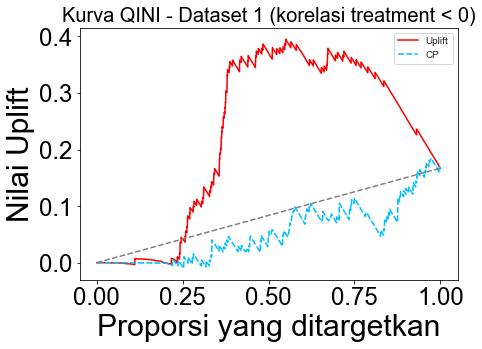

In [21]:
# hasil evaluasi QINI untuk dataset 1
ax, qini_1 = evaluasi_qini(hasil_prediksi_1)
plt.title('Kurva QINI - Dataset 1 (korelasi treatment < 0)',fontsize=20)
plt.savefig('QINI_1_n.pdf', bbox_inches='tight')

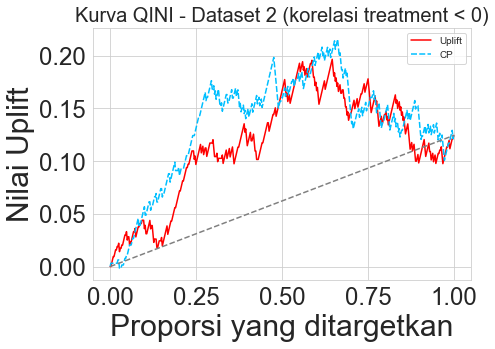

In [22]:
# hasil evaluasi QINI untuk dataset 2
ax, qini_2 = evaluasi_qini(hasil_prediksi_2)
plt.title('Kurva QINI - Dataset 2 (korelasi treatment < 0)',fontsize=20)
plt.savefig('QINI_2_n.pdf', bbox_inches='tight')

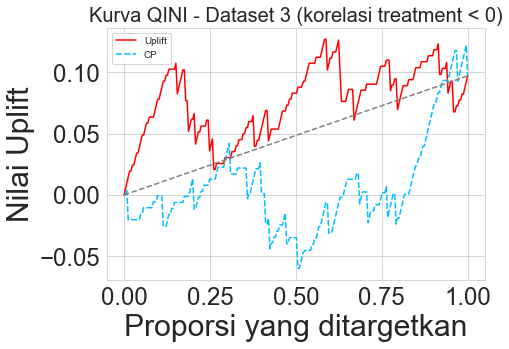

In [23]:
# hasil evaluasi QINI untuk dataset 3
ax, qini_3 = evaluasi_qini(hasil_prediksi_3)
plt.title('Kurva QINI - Dataset 3 (korelasi treatment < 0)',fontsize=20)
plt.savefig('QINI_3_n.pdf', bbox_inches='tight')

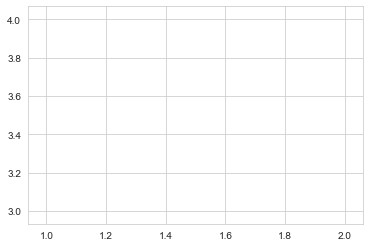

In [24]:
# Menyiapkan bentuk kotak dan segitiga untuk swarmplot distribusi target class
fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='s')
b = ax.scatter([1,2],[3,4], marker='^')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()
def distribusi_target_class(df_1:pd.DataFrame,
                            df_2:pd.DataFrame,
                            df_3:pd.DataFrame,
                            target_class:str):
    """Fungsi untuk memvisualisasikan swarmplot target class"""
    # menambahkan kolom dataset
    df_1['dataset'] = 'Dataset 1'
    df_2['dataset'] = 'Dataset 2'
    df_3['dataset'] = 'Dataset 3'
    # menggabungkan dan mengurutkan ketiga dataset
    df = pd.concat([df_1, df_2, df_3])
    df = df.sort_values(by='n')[:round(len(df)/4)]
    
    
    # menyiapkan swarmplot
    ax = sns.swarmplot(data=df[df.target_class==target_class],
                       x='dataset',
                       y='n',
                       hue='model',
                       palette=['deepskyblue','red'],
                       hue_order=['CP', 'Uplift'],
                       order=['Dataset 1', 'Dataset 2', 'Dataset 3'], size=5)
    collections = ax.collections
    unique_colors = np.unique(collections[0].get_facecolors(),axis=0)
    markers = [square_mk, triangle_up_mk]
    for collection in collections:
        paths = []
        for current_color in collection.get_facecolors():
            for possible_marker,possible_color in zip(markers, unique_colors):
                if np.array_equal(current_color,possible_color):
                    paths.append(possible_marker)
                    break
        collection.set_paths(paths)
        
    
    # menambah pengaturan tampilan swarmplot
    ax.tick_params(labelsize=24)   
    ax.legend(collections[-2:],pd.unique(df.model))  
    plt.ylabel('Proporsi yang Ditargetkan',fontsize=30)
    plt.xlabel('')
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=20)
    return ax

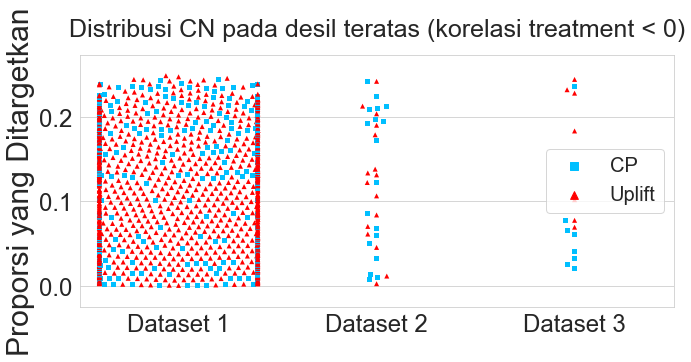

In [25]:
# Memvisualisasikan swarmplot distribusi target class CN
distribusi_target_class(qini_1, qini_2, qini_3, 0)
plt.title('Distribusi CN pada desil teratas (korelasi treatment < 0)',fontsize=25, y=1.05)
plt.savefig('CN_n.pdf', bbox_inches='tight')

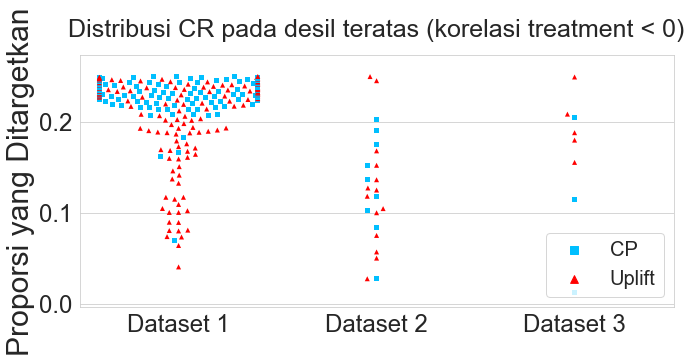

In [26]:
distribusi_target_class(qini_1, qini_2, qini_3, 1)
plt.title('Distribusi CR pada desil teratas (korelasi treatment < 0)',fontsize=25, y=1.05)
plt.savefig('CR_n.pdf', bbox_inches='tight')

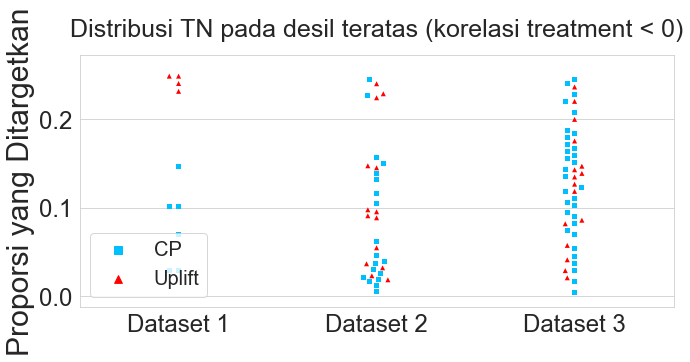

In [27]:
distribusi_target_class(qini_1, qini_2, qini_3, 2)
plt.title('Distribusi TN pada desil teratas (korelasi treatment < 0)',fontsize=25, y=1.05)
plt.savefig('TN_n.pdf', bbox_inches='tight')

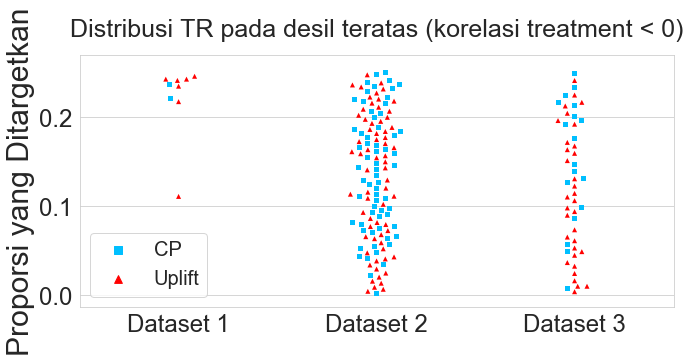

In [28]:
distribusi_target_class(qini_1, qini_2, qini_3, 3)
plt.title('Distribusi TR pada desil teratas (korelasi treatment < 0)',fontsize=25, y=1.05)
plt.savefig('TR_n.pdf', bbox_inches='tight')

In [29]:
# Proses inverse nilai treatment
df_model_inverse_1.treatment = df_model_inverse_1.treatment.replace({0: 1, 1: 0})
df_model_inverse_2.treatment = df_model_inverse_2.treatment.replace({0: 1, 1: 0})
df_model_inverse_3.treatment = df_model_inverse_3.treatment.replace({0: 1, 1: 0})

In [30]:
# menghitung kembali korelasi treatment
display(korelasi_treatment(df_model_inverse_1).iloc[0,0])
display(korelasi_treatment(df_model_inverse_2).iloc[0,0])
display(korelasi_treatment(df_model_inverse_3).iloc[0,0])

6.18

24.61

4.0

In [31]:
# menambah feature target class pada ketiga dataset
df_model_inverse_1, df_model_inverse_2, df_model_inverse_3 = deklarasi_target_class(df_model_inverse_1), \
deklarasi_target_class(df_model_inverse_2), deklarasi_target_class(df_model_inverse_3)

In [32]:
# Proses pemodelan machine learning
hasil_prediksi_inverse_1 = model_machine_learning(df_model_inverse_1)
hasil_prediksi_inverse_2 = model_machine_learning(df_model_inverse_2)
hasil_prediksi_inverse_3 = model_machine_learning(df_model_inverse_3)

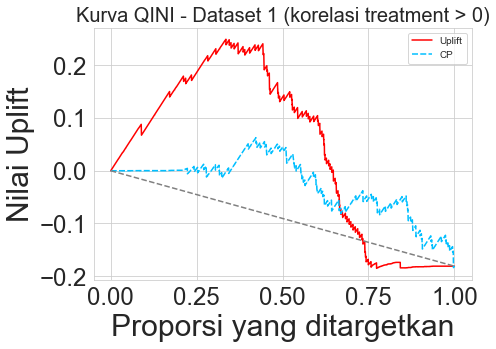

In [33]:
# hasil evaluasi QINI untuk dataset 1
ax, qini_inverse_1 = evaluasi_qini(hasil_prediksi_inverse_1)
plt.title('Kurva QINI - Dataset 1 (korelasi treatment > 0)',fontsize=20)
plt.savefig('QINI_1_p.pdf', bbox_inches='tight')

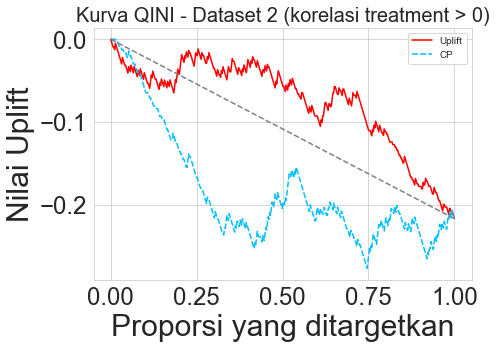

In [34]:
# hasil evaluasi QINI untuk dataset 2
ax, qini_inverse_2 = evaluasi_qini(hasil_prediksi_inverse_2)
plt.title('Kurva QINI - Dataset 2 (korelasi treatment > 0)',fontsize=20)
plt.savefig('QINI_2_p.pdf', bbox_inches='tight')

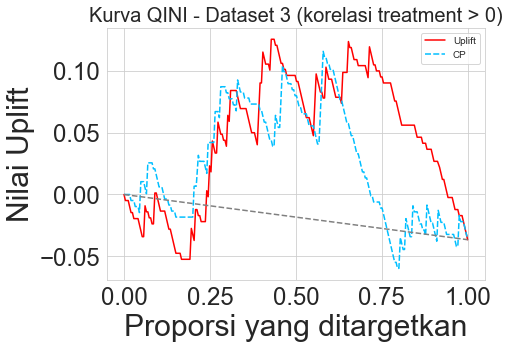

In [35]:
# hasil evaluasi QINI untuk dataset 3
ax, qini_inverse_3 = evaluasi_qini(hasil_prediksi_inverse_3)
plt.title('Kurva QINI - Dataset 3 (korelasi treatment > 0)',fontsize=20)
plt.savefig('QINI_3_p.pdf', bbox_inches='tight')

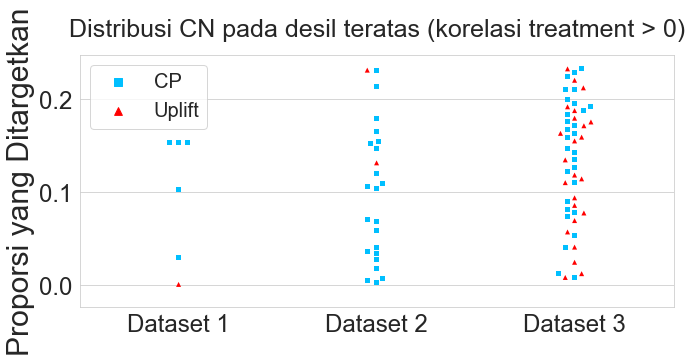

In [36]:
# Memvisualisasikan swarmplot distribusi target class CN
distribusi_target_class(qini_inverse_1, qini_inverse_2, qini_inverse_3, 0)
plt.title('Distribusi CN pada desil teratas (korelasi treatment > 0)',fontsize=25, y=1.05)
plt.savefig('CN_p.pdf', bbox_inches='tight')

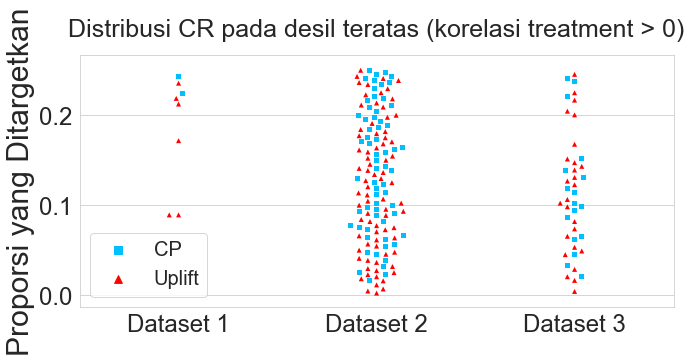

In [37]:
distribusi_target_class(qini_inverse_1, qini_inverse_2, qini_inverse_3, 1)
plt.title('Distribusi CR pada desil teratas (korelasi treatment > 0)',fontsize=25, y=1.05)
plt.savefig('CR_p.pdf', bbox_inches='tight')

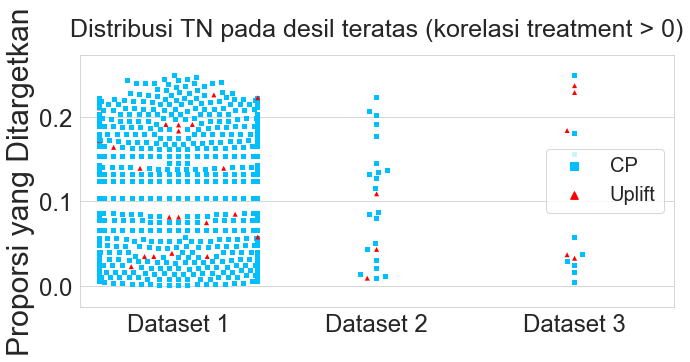

In [38]:
distribusi_target_class(qini_inverse_1, qini_inverse_2, qini_inverse_3, 2)
plt.title('Distribusi TN pada desil teratas (korelasi treatment > 0)',fontsize=25, y=1.05)
plt.savefig('TN_p.pdf', bbox_inches='tight')

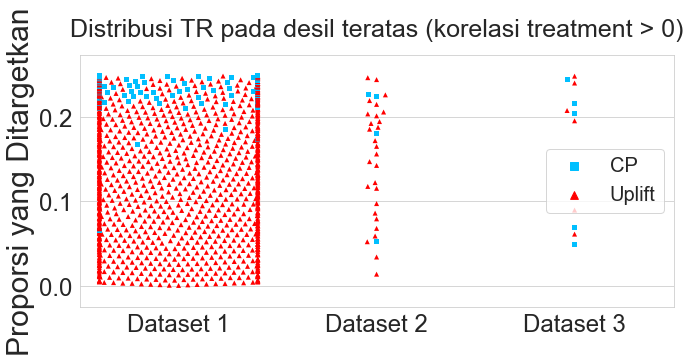

In [39]:
distribusi_target_class(qini_inverse_1, qini_inverse_2, qini_inverse_3, 3)
plt.title('Distribusi TR pada desil teratas (korelasi treatment > 0)',fontsize=25, y=1.05)
plt.savefig('TR_p.pdf', bbox_inches='tight')